In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
background_seq_ids = pd.read_csv('../data/interim/background_seq_ids.csv')
cog_background_seq_ids = pd.read_parquet('../data/interim/cog_filtered_seq_ids.pq')
secrete_background_seq_ids = pd.read_csv('../data/interim/secreted_homologs.csv')

In [3]:
defense_homolog_df = (pd.read_parquet('../data/interim/defense_finder_homologs_profile_names.pq')
                      .drop_duplicates())
true_defense_genes = pd.read_parquet('../data/interim/defense_finder_true_defense_seq_ids.pq')
go_df = pd.read_parquet('../data/interim/seq_id_go_processes.pq')
seq_id_names = pd.read_parquet('../data/interim/seq_id_names.pq')

In [4]:
all_background_seq_ids = (pd.concat([background_seq_ids['seq_id'],
                                     cog_background_seq_ids['seq_id'],
                                     secrete_background_seq_ids['target']], 
                                    axis=0)
                          .drop_duplicates()
                          .reset_index(drop=True))

### Defense homologs

If a gene **might** (p>0.4) be defenseive based on its homology to known defense genes, then don't include it in the negative set. i.e., if p(defense|homolog)>0.4, remove gene from the negative list

In [5]:
defense_homolog_df['true_defense'] = defense_homolog_df['seq_id'].isin(true_defense_genes['seq_id'])
defense_homolog_stats = (defense_homolog_df.groupby('gene_name')
                         .agg(background_count = ('seq_id', 'count'), 
                              defense_count = ('true_defense', 'sum'))
                         .reset_index())
defense_homolog_stats['defense_percent'] = (defense_homolog_stats['defense_count']/
                                            defense_homolog_stats['background_count'])

<Axes: xlabel='defense_percent', ylabel='Count'>

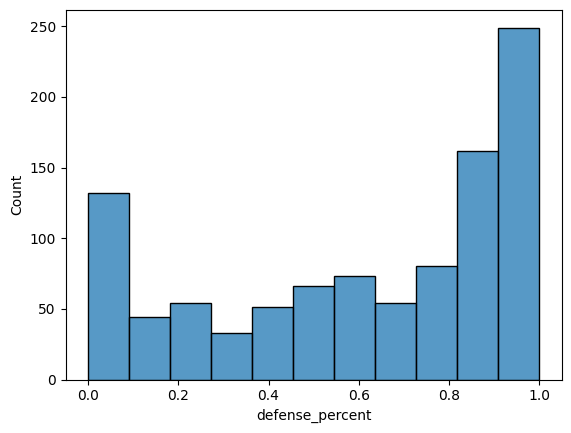

In [6]:
sns.histplot(data=defense_homolog_stats, x='defense_percent')

In [7]:
defense_genes = defense_homolog_stats.loc[defense_homolog_stats['defense_percent'] > 0.4, 
                                          'gene_name'].unique()

In [8]:
defense_gene_seq_ids = defense_homolog_df.loc[defense_homolog_df['gene_name'].isin(defense_genes), 
                                              'seq_id'].drop_duplicates()

If a gene **might** (p>0.4) be defenseive based on its name, then don't include it in the negative set. i.e., if p(defense|name)>0.4, remove gene from the negative list

In [9]:
seq_id_names['true_defense'] = seq_id_names['seq_id'].isin(true_defense_genes['seq_id'])

In [10]:
defense_name_stats = (seq_id_names.groupby('name')
                         .agg(background_count = ('seq_id', 'count'), 
                              defense_count = ('true_defense', 'sum'))
                         .reset_index())
defense_name_stats['defense_percent'] = (defense_name_stats['defense_count']/
                                            defense_name_stats['background_count'])

<Axes: xlabel='defense_percent', ylabel='Count'>

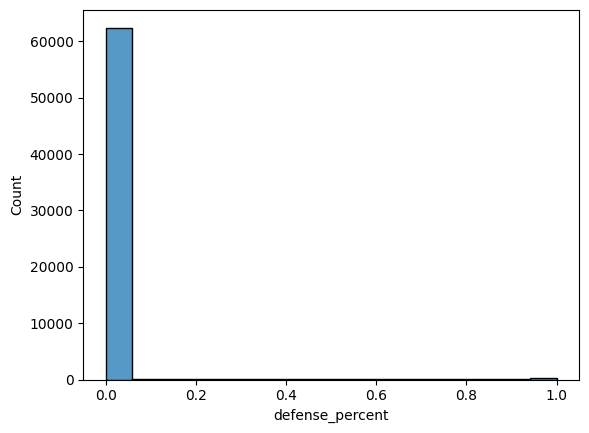

In [11]:
sns.histplot(data=defense_name_stats, x='defense_percent')

In [12]:
(defense_name_stats[defense_name_stats['defense_percent'] > 0.4]
 .sort_values('defense_percent', ascending=False).tail(10))

,name,background_count,defense_count,defense_percent
18639,NaeI family type II restriction endonuclease,267,113,0.423221
4751,DISARM system helicase DrmA,549,232,0.422587
54343,restriction endonuclease BsuBI,19,8,0.421053
17610,N-6 DNA methylase,13796,5803,0.420629
7887,DUF3696 domain-containing protein,844,355,0.420616
21116,RNA-directed DNA polymerase,2035,853,0.419165
3126,BREX system ATP-binding protein BrxD,528,220,0.416667
5237,DNA sulfur modification protein DndD,750,311,0.414667
20546,PmeII family type II restriction endonuclease,160,66,0.412500
6811,DUF2397 domain-containing protein,226,93,0.411504


In [13]:
defense_names = defense_name_stats.loc[defense_name_stats['defense_percent'] > 0.4, 
                                       'name']

In [14]:
defense_name_seq_ids = seq_id_names.loc[seq_id_names['name'].isin(defense_names),
                                        'seq_id'].drop_duplicates()

If a gene **might** (p>0.4) be defenseive based on its GO term, then don't include it in the negative set. i.e., if p(defense|GO term)>0.4, remove gene from the negative list

In [15]:
# from notebook 04_00
defensive_go_terms = ['maintenance of CRISPR repeat elements',
                      'DNA modification',
                      'DNA methylation',
                      'DNA restriction-modification system',
                      'defense response to virus',
                      'nucleic acid phosphodiester bond hydrolysis']

In [16]:
defense_go_term_seq_ids = go_df.loc[go_df['go_process'].isin(defensive_go_terms), 
                                    'seq_id'].drop_duplicates()

In [17]:
defense_seq_ids = (pd.concat([defense_gene_seq_ids, 
                             defense_name_seq_ids, 
                             defense_go_term_seq_ids], axis=0)
                   .drop_duplicates()
                   .reset_index(drop=True))

In [18]:
filtered_background_seq_ids = all_background_seq_ids[~all_background_seq_ids.isin(defense_seq_ids)]
print(len(filtered_background_seq_ids))
len(filtered_background_seq_ids)/len(all_background_seq_ids)

14105320


0.9998270455408939

### Pick sequences from each cluster

Note that we're use using the mode 1 clustering, which uses connected components to define clusters as opposed to centroids

In [19]:
%%time
all_clusters = pd.read_table('../data/interim/refseqs_clusters_mode1.tsv',
                                      names=['cluster_id', 'seq_id'])
background_clusters = (all_clusters[all_clusters['seq_id'].isin(filtered_background_seq_ids)]
                                .reset_index(drop=True))
del all_clusters

CPU times: user 1min 41s, sys: 7.95 s, total: 1min 49s
Wall time: 1min 49s


Pick 5 sequences from each cluster

In [20]:
model_clusters = (background_clusters
                  .sample(frac=1, random_state=7)
                  .groupby('cluster_id')
                  .head(5))

In [21]:
model_background_seqs = model_clusters['seq_id'].to_list()

In [22]:
len(model_background_seqs)

1883738

In [23]:
%%time 
protein_genomes = pd.read_csv('../data/interim/seq_assemblies.csv', 
                              names=['protein_id', 'seq_id', 'seq', 'assembly'])
background_seq_genomes = (protein_genomes[protein_genomes['seq_id'].isin(model_background_seqs)]
                          .reset_index(drop=True))
del protein_genomes

CPU times: user 5min 22s, sys: 30.8 s, total: 5min 53s
Wall time: 5min 54s


In [24]:
background_sampled_genomes = (background_seq_genomes.groupby('seq_id')
                              .sample(n=1, random_state=7))
del background_seq_genomes

In [25]:
# check notebook 03_02 to make sure this is the right split
test_n = 10_128
val_n = 4_434
train_n = 99_642
total_n = test_n + val_n + train_n
test_split_frac = test_n/total_n
val_split_frac =  val_n/total_n
print('test split', test_split_frac)
print('val split', val_split_frac)

test split 0.08868340863717558
val split 0.03882526006094358


## Pick val and test data splitting by homology

In [26]:
background_clusters['cluster_id'].value_counts().head(20)

cluster_id
858c34fd356e0283c293c1dcef05787a75433eefff8471b9121d9390    37426
61a34c58ac6f3e7ec7a7ed2498f51d4eebb67f1d8ea75e05159e80ce    35091
d73c009eb2c1a254a61c205edeb6f726fa3a8a324a59fb21a5abbd95    33577
294709ac7e59a7a9264751c2ba8181f6b8ac3775c7af540d9e4c5772    32611
52fdd92538fd290ab2f55a54d9c80d9ee012e26806150fb32a3e8338    31332
0b6417bcd184f0f762786ed3cb2ab66bd2b8b1ef1f6de5d093c7c889    25617
06612666691cc45a525c517d529684159496ceb42a79e0ec6d755896    24441
3fa670843dbcb32f5a4f2dcc03e30eb48026e014812b3443f7c18966    23841
f205e9d77c22e39bda1cd63cacd04148dc33c07627d41b8813b77373    22834
63aa45b8f64e772764b15bd7325b205f2df574910813c82dc43a51e4    22545
c1861331241514141f781b1c9f8b8702a68b1ec20848c1e658d8d749    22313
1cdb643d8d3a502c33da4eb00802371afc2cc410ec19f9e153b82461    22164
8a04c314de61ab64fa69401aa9c536d31f368e81450722f58f5edc5c    21590
5e0e22d7de91f2ae8cd0695561ef41b530fc9423d56b3755dcf1f287    21514
a89604bda07b3bb2724d5b93c1f4ab23a74250a3c091d9c6393cc69d    20501

In [27]:
background_connected_cluster_ids = background_clusters['cluster_id'].drop_duplicates()

In [28]:
len(background_connected_cluster_ids)

1078622

In [29]:
train_val_cluster_ids, test_cluster_ids = train_test_split(background_connected_cluster_ids, test_size=test_split_frac, 
                                                           random_state=7)


In [30]:
new_val_split_frac = ((val_split_frac*len(background_connected_cluster_ids))/
                      (len(background_connected_cluster_ids)-len(test_cluster_ids)))
print('new val split frac', new_val_split_frac)
train_cluster_ids, val_cluster_ids = train_test_split(train_val_cluster_ids, test_size=new_val_split_frac)

new val split frac 0.04260348746289809


In [31]:
print('test cluster frac',len(test_cluster_ids)/len(background_connected_cluster_ids))
print('desired test cluster frac:', test_split_frac)

test cluster frac 0.08868352397781613
desired test cluster frac: 0.08868340863717558


In [32]:
print('val cluster frac',len(val_cluster_ids)/len(background_connected_cluster_ids))
print('desired val cluster frac', val_split_frac)

val cluster frac 0.038825464342466594
desired val cluster frac 0.03882526006094358


In [33]:
cluster_splits = pd.DataFrame({'cluster_id': val_cluster_ids.to_list() + test_cluster_ids.to_list(), 
                               'split': ['val']*len(val_cluster_ids) + ['test']*len(test_cluster_ids)})
cluster_splits = (cluster_splits
                  .merge(background_clusters[['cluster_id']].drop_duplicates(), 
                         how='right', on='cluster_id'))
cluster_splits['split'] = cluster_splits['split'].fillna('train')

In [34]:
background_split_seqs = (background_sampled_genomes
                         .merge(background_clusters, how='inner', 
                                on='seq_id')
                         .merge(cluster_splits, how='inner', on='cluster_id'))

In [35]:
background_seq_id_split = background_split_seqs['split'].value_counts()
background_seq_id_split

split
train    1644397
test      166243
val        73098
Name: count, dtype: int64

In [36]:
background_seq_id_split['test']/(background_seq_id_split.sum())

0.08825165707757661

In [37]:
background_seq_id_split['val']/(background_seq_id_split.sum())

0.03880475947292033

In [38]:
background_split_seqs.head()

,protein_id,seq_id,seq,assembly,cluster_id,split
0,WP_146903048.1,00000031de6e3b5adb7f0ecb501bce05d5aebd9f5c2d64...,MRRHGVLGTLAAGLAALAITVTAASPAAAIRYGEPDAGEHPYVGLM...,GCF_007991755,84db8c4f92fb99dbe4c68a77965aebf3d0a6415fb45870...,train
1,WP_034223345.1,630eedef674c705d4c3f1a80262a4078b919053d962075...,MRFTRAAVAFVAALGLAAATAAPAAAIRYGEPDDGEHPYVGIMIAY...,GCF_000603945,84db8c4f92fb99dbe4c68a77965aebf3d0a6415fb45870...,train
2,WP_022922928.1,84db8c4f92fb99dbe4c68a77965aebf3d0a6415fb45870...,MRFTKPVLSLSAVTALTLSLAAPASAITFGEPDNGEHPFVGIMVAL...,GCF_000421185,84db8c4f92fb99dbe4c68a77965aebf3d0a6415fb45870...,train
3,WP_269813396.1,96e1190b92e1bc534871c42f763c30150b07842e443fa4...,MVALVENPEGALVPAWRCSGALVDSTHFLTAGHCTYGADSVEIWFS...,GCF_021272345,84db8c4f92fb99dbe4c68a77965aebf3d0a6415fb45870...,train
4,WP_199422010.1,bd23691f0bc6ce6b93b6f6468980236a3a232a681d29a9...,MVRKKTLLGGALAGLCAVALTLAAATPAAAIRYGEPDAGEHPYVGL...,GCF_016464425,84db8c4f92fb99dbe4c68a77965aebf3d0a6415fb45870...,train


In [39]:
background_split_seqs.to_parquet('../data/interim/background_model_seqs.pq', index=False)

In [2]:
background_split_seqs = pd.read_parquet('../data/interim/background_model_seqs.pq')

In [3]:
(background_split_seqs.groupby('split')
 .agg({'cluster_id': 'nunique'}))

,cluster_id
split,
test,95656
train,941088
val,41878
